# Dataset Friuli-Venezia Giulia
Registrazione delle misure combinate di [ARPAFVG](https://www.osmer.fvg.it/home.php), ISAC e SCIA.

La procedura si articola nei seguenti passaggi:
1. [caricamento dei dati grezzi](#caricamento-da-frammenti) e uniformazione negli schemi esposti sotto;
2. [overview disponibilità dati](#overview-disponibilità-dati): plot che mostrano la disponibilità temporale e spaziale di serie;
3. [primo quality check](#quality-check): controllo errori di consistenza nella singola serie e nelle coppie di serie della stessa stazione;
4. [merging](#merging) del dataset.

## Data model
### Metadati
#### Dataset
| name   | source | kind   | description |
|--------|--------|--------|-------------|
| utf8() | utf8() | utf8() | utf8()      |
| pkey   | obs    | obs    | obs         |

Campi:
- in `name` l'identificativo (univoco) del dataset;
- in `source` un'indicazione di dove è possibile reperire i dati (possibilmente url); 
- in `kind` "national" o "regional";
- in `description` qualche informazione sul dataset.

#### Station
| dataset | id   | name | network | state | lon    | lat    | elevation | first_registration | last_registration | valid_days | previous_dataset | previous_id |
|---------|------|------|---------|-------|--------|--------|-----------|--------------------|-------------------|------------|------------------|-------------|
| utf8()  |int() |utf8()| utf8()  | utf8()|double()|double()| double()  | date32()           | date32()          | int()      | utf8()           | utf8()      |
| pkey    | pkey | obs  | obs     | obs   | obs    | obs    | obs       | obs                | obs               | obs        | fkey             | obs         |

I metadati delle stazioni che non rientrano nella tabella vanno in una tabella "extra" collegata tramite `dataset` e `id`.

### Data
| dataset   | station_id | variable | date     | value     |
|-----------|------------| -------- | -------- | --------- |
| utf8()    | int()      | utf8()   | date32() | float64() |
| pkey/fkey | pkey/fkey  | pkey     | pkey     | obs       |


## Caricamento librerie e dichiarazione del dataset
Scrivere nel file `load_daily.R` una funzione `dataset_spec()` che fornisca in lista le informazioni sul dataset da caricare nel database.

In [1]:
dataset <- "ARPAFVG"
state <- "Friuli-Venezia Giulia"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
library(DBI, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

source(str_glue("notebooks/ds_regionali/FVG/procedures/load_daily.R"))
source("notebooks/ds_regionali/procedure/common_steps.R")
source("notebooks/ds_regionali/procedure/checkpoint.R")
source("notebooks/ds_regionali/procedure/tools.R")
source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")
add_ds_info(dataset, dataset_spec())


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



## Uniformazione dei dati
Produzione di un checkpoint da dati raw. Scrivere una funzione `load_daily_data.<dataset>(first_date, last_date)` nel file `load_daily.R` che restituisca un dizionario con elementi:
- `meta`: una tabella con (almeno) i campi da `dataset` a `state` compilati;
- `data`: una tabella Arrow già nel formato standard.

Le funzioni di `common_steps` si occupano di completare ed effettuare il checkpoint.


In [32]:
old_metas <- query_parquet(str_c(file.path("db", "metadata", "raw", c("ARPAFVG", "SCIA", "ISAC")), ".parquet")) |>
    collect() |>
    filter(is.na(state) | state == "Friuli-Venezia Giulia", 45.5 < lat, lat < 46.68, 12.3 < lon, lon < 14, !str_starts(series_id, "AT_"))
new_metas <- query_checkpoint_meta(c("ARPAFVG", "SCIA", "ISAC"), "raw", conns$data) |>
    collect() |>
    filter(is.na(state) | state == "Friuli-Venezia Giulia", 45.5 < lat, lat < 46.68, 12.3 < lon, lon < 14, !str_starts(series_id, "AT_"))


In [49]:
trans1 <- old_metas |> inner_join(new_metas, by = c("user_code", "dataset", "name", "series_id"), suffix = c("_old", "_new"))

In [51]:
library(openxlsx)
trans1 |> select(dataset, sensor_key_old, sensor_key_new, name) |> write.xlsx("trans.xlsx")

In [43]:
om1 <- old_metas |> anti_join(trans1, by = c("dataset", "sensor_key" = "sensor_key.x"))
nm1 <- new_metas |> anti_join(trans1, by = c("dataset", "sensor_key" = "sensor_key.y"))

In [45]:
om1 |> select(series_id, name)

series_id,name
<chr>,<chr>
FVG_UD_ALESSO_02_000401500,ALESSO
FVG_PN_ANDREIS_02_000103600,ANDREIS
FVG_PN_ARBA_02_000100600,ARBA
FVG_PN_ARZENUTTO_02_000100800,ARZENUTTO
FVG_PN_AVIANO_02_000502800,AVIANO
FVG_UD_AZZIDA_02_000231900,AZZIDA
FVG_PN_BALDASS_02_000503900,BALDASS
FVG_PN_BARCIS_02_000103400,BARCIS
FVG_PN_BASALDELLA_DI_VIVARO_02_000503000,BASALDELLA_DI_VIVARO


In [33]:
old_metas |> st_md_to_sf()


sensor_key sensor_id station_key sensor_first sensor_last station_id
1    1         NA         1          2009-01-01   2024-01-22  103400    
2    2         NA         2          2009-01-01   2024-01-22  178200    
3    4         NA         4          2009-01-01   2024-01-22  231600    
4    5         NA         5          2014-01-16   2024-01-22  ARI       
5    6         NA         6          2004-12-03   2021-02-17  BAR       
6    7         NA         7          2022-01-01   2022-12-31  BGG       
7    8         NA         8          2008-05-06   2024-01-22  BIC       
8    9         NA         9          2002-10-03   2024-01-22  BOA       
9   10         NA        10          2004-08-24   2021-04-20  BOR       
10  11         NA        11          1990-08-01   2024-01-22  BRU       
11  12         NA        12          1990-08-28   2024-01-22  CAP       
12  13         NA        13          2006-10-27   2024-01-22  CDP       
13  14         NA        14          1992-07-22   2024-01-22  CER       
14  15         NA        15          2004-07-02   2022-12-31  CHI       
15  16         NA        16          1999-08-11   2024-01-22  CIV       
16  17         NA        17          2014-01-16   2022-12-31  CMT       
17  18         NA        18          2000-04-01   2024-01-22  COD       
18  19         NA        19          2015-10-03   2021-03-29  CRV       
19  20         NA        20          1994-07-27   2024-01-22  ENE       
20  21         NA        21          1990-09-13   2019-06-19  FAE       
21  22         NA        22          1990-09-13   2024-01-22  FAG       
22  23         NA        23          1990-08-01   2024-01-22  FOS       
23  24         NA        24          2004-07-05   2024-01-22  FSP       
24  25         NA        25          1999-07-29   2024-01-22  GEM       
25  26         NA        26          1990-08-10   2024-01-22  GRA       
26  27         NA        27          2000-01-01   2019-09-11  GRD       
27  28         NA        28          2008-07-28   2024-01-22  GRG       
28  30         NA        30          2008-06-18   2024-01-22  LAU       
29  31         NA        31          1999-07-01   2024-01-22  LIG       
30  32         NA        32          2017-02-17   2024-01-22  LSR       
... ...        ...       ...         ...          ...         ...       
451 3698       NA         815        2023-02-01   2023-08-31  NA        
452 3699       NA         934        2023-02-01   2023-08-31  NA        
453 3700       NA         936        2023-02-01   2023-08-31  NA        
454 3701       NA         820        2023-02-01   2023-08-31  NA        
455 3702       NA         945        2023-02-01   2023-08-31  NA        
456 3703       NA         948        2023-02-01   2023-08-31  NA        
457 3704       NA         951        2023-02-01   2023-08-31  NA        
458 3705       NA         858        2023-02-01   2023-08-31  NA        
459 3706       NA         954        2023-02-01   2023-08-31  NA        
460 3707       NA         862        2023-02-01   2023-08-31  NA        
461 3708       NA         969        2023-02-01   2023-08-31  NA        
462 3709       NA         973        2023-02-01   2023-08-31  NA        
463 3710       NA         883        2023-02-01   2023-08-31  NA        
464 3711       NA         981        2023-02-01   2023-08-31  NA        
465 3712       NA         987        2023-02-01   2023-08-31  NA        
466 3713       NA         989        2023-02-01   2023-08-31  NA        
467 3714       NA         823        2023-02-01   2023-08-31  NA        
468 3715       NA         992        2023-02-01   2023-08-31  NA        
469 3716       NA         886        2023-02-01   2023-08-31  NA        
470 3717       NA         993        2023-02-01   2023-08-31  NA        
471 3718       NA         999        2023-02-01   2023-08-31  NA        
472 3719       NA        1001        2023-02-01   2023-08-31  NA        
473 3720       NA         887        2023-02-01   2023-08-30  

In [16]:
new_metas


gestore,name,user_code,kind,lat,lon,elevation,series_first
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<date>
Protezione Civile FVG,Adegliacco,329100,SIAP+MICROS,46.11525,13.22900,139,2002-06-18
Protezione Civile FVG,Alesso,401500,SIAP+MICROS,46.30922,13.05565,213,2005-06-16
Protezione Civile FVG,Alnicco,328900,SIAP+MICROS,46.11783,13.16578,186,2002-06-18
Protezione Civile FVG,Andreis,103600,SIAP+MICROS,46.19888,12.61183,455,2000-11-30
Protezione Civile FVG,Arba,100600,SIAP+MICROS,46.14261,12.80824,176,1990-10-17
Protezione Civile FVG,Ariis,ARI,SIAP+MICROS,45.87830,13.09000,13,2014-01-16
Protezione Civile FVG,Arzenutto,100800,SIAP+MICROS,46.01659,12.87055,65,1991-01-09
Protezione Civile FVG,Aviano,502800,SIAP+MICROS,46.06435,12.60278,150,2009-05-19
Protezione Civile FVG,Azzida,231900,SIAP+MICROS,46.11836,13.49472,165,1999-09-24


In [3]:
daily_dataset <- load_daily_data.arpafvg() |> prepare_daily_data(conns$stations)
save_checkpoint(daily_dataset$checkpoint, dataset, "raw", partitioning = "variable")
write_extra_metadata(daily_dataset$extra_meta |> collect(), dataset, conns$stations)
rm(daily_dataset)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2042748,109.1,3999082,213.6,NA,3999082,213.6
Vcells,3659677,28.0,8388608,64.0,16384,5127989,39.2


In [4]:
qc_checkpoint(dataset, conns$data)


In [9]:
old_keys <- query_parquet(str_c(file.path("db", "metadata", "raw", c("ARPAFVG", "SCIA", "ISAC")), ".parquet")) |> filter(is.na(state) | state == "Friuli-Venezia Giulia")
new_keys <- query_checkpoint_meta(c("ARPAFVG", "SCIA", "ISAC"), "raw", conns$data) |> filter(is.na(state) | state == "Friuli-Venezia Giulia")


In [7]:
old_keys |> collect()


sensor_key,sensor_id,station_key,sensor_first,sensor_last,station_id,name,network,town,province_full,...,user_code,series_key,kind,lon,lat,elevation,series_id,dataset,series_first,series_last
<int>,<chr>,<int>,<date>,<date>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<date>,<date>
1,NA,1,2009-01-01,2024-01-22,103400,Barcis,ARPAFVG,NA,Pordenone,...,103400,1,unknown,12.57103,46.19320,468,103400,ARPAFVG,2009-01-01,2024-01-22
2,NA,2,2009-01-01,2024-01-22,178200,Grado Meteo,ARPAFVG,NA,NA,...,178200,2,unknown,13.37329,45.68035,0,178200,ARPAFVG,2009-01-01,2024-01-22
4,NA,4,2009-01-01,2024-01-22,231600,Musi 2,ARPAFVG,NA,Udine,...,231600,4,unknown,13.27258,46.30727,600,231600,ARPAFVG,2009-01-01,2024-01-22
5,NA,5,2014-01-16,2024-01-22,ARI,Ariis,ARPAFVG,NA,Udine,...,ARI,5,unknown,13.09000,45.87830,13,ARI,ARPAFVG,2014-01-16,2024-01-22
6,NA,6,2004-12-03,2021-02-17,BAR,Barcis (fino al 18/02/2021),ARPAFVG,NA,Pordenone,...,BAR,6,unknown,12.57103,46.19320,468,BAR,ARPAFVG,2004-12-03,2021-02-17
7,NA,7,2022-01-01,2022-12-31,BGG,Borgo Grotta Gigante,ARPAFVG,NA,Trieste,...,BGG,7,unknown,13.76468,45.70938,275,BGG,ARPAFVG,2022-01-01,2022-12-31
8,NA,8,2008-05-06,2024-01-22,BIC,Bicinicco,ARPAFVG,NA,Udine,...,BIC,8,unknown,13.24014,45.92881,33,BIC,ARPAFVG,2008-05-06,2024-01-22
9,NA,9,2002-10-03,2024-01-22,BOA,Boa Paloma (fino al 06/02/2018),ARPAFVG,NA,NA,...,BOA,9,unknown,13.56502,45.61829,5,BOA,ARPAFVG,2002-10-03,2024-01-22
10,NA,10,2004-08-24,2021-04-20,BOR,Bordano (fino al 21/04/2021),ARPAFVG,NA,Udine,...,BOR,10,unknown,13.08120,46.33276,230,BOR,ARPAFVG,2004-08-24,2021-04-20


## Controllo disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese e sul territorio a confronto con SCIA e ISAC.

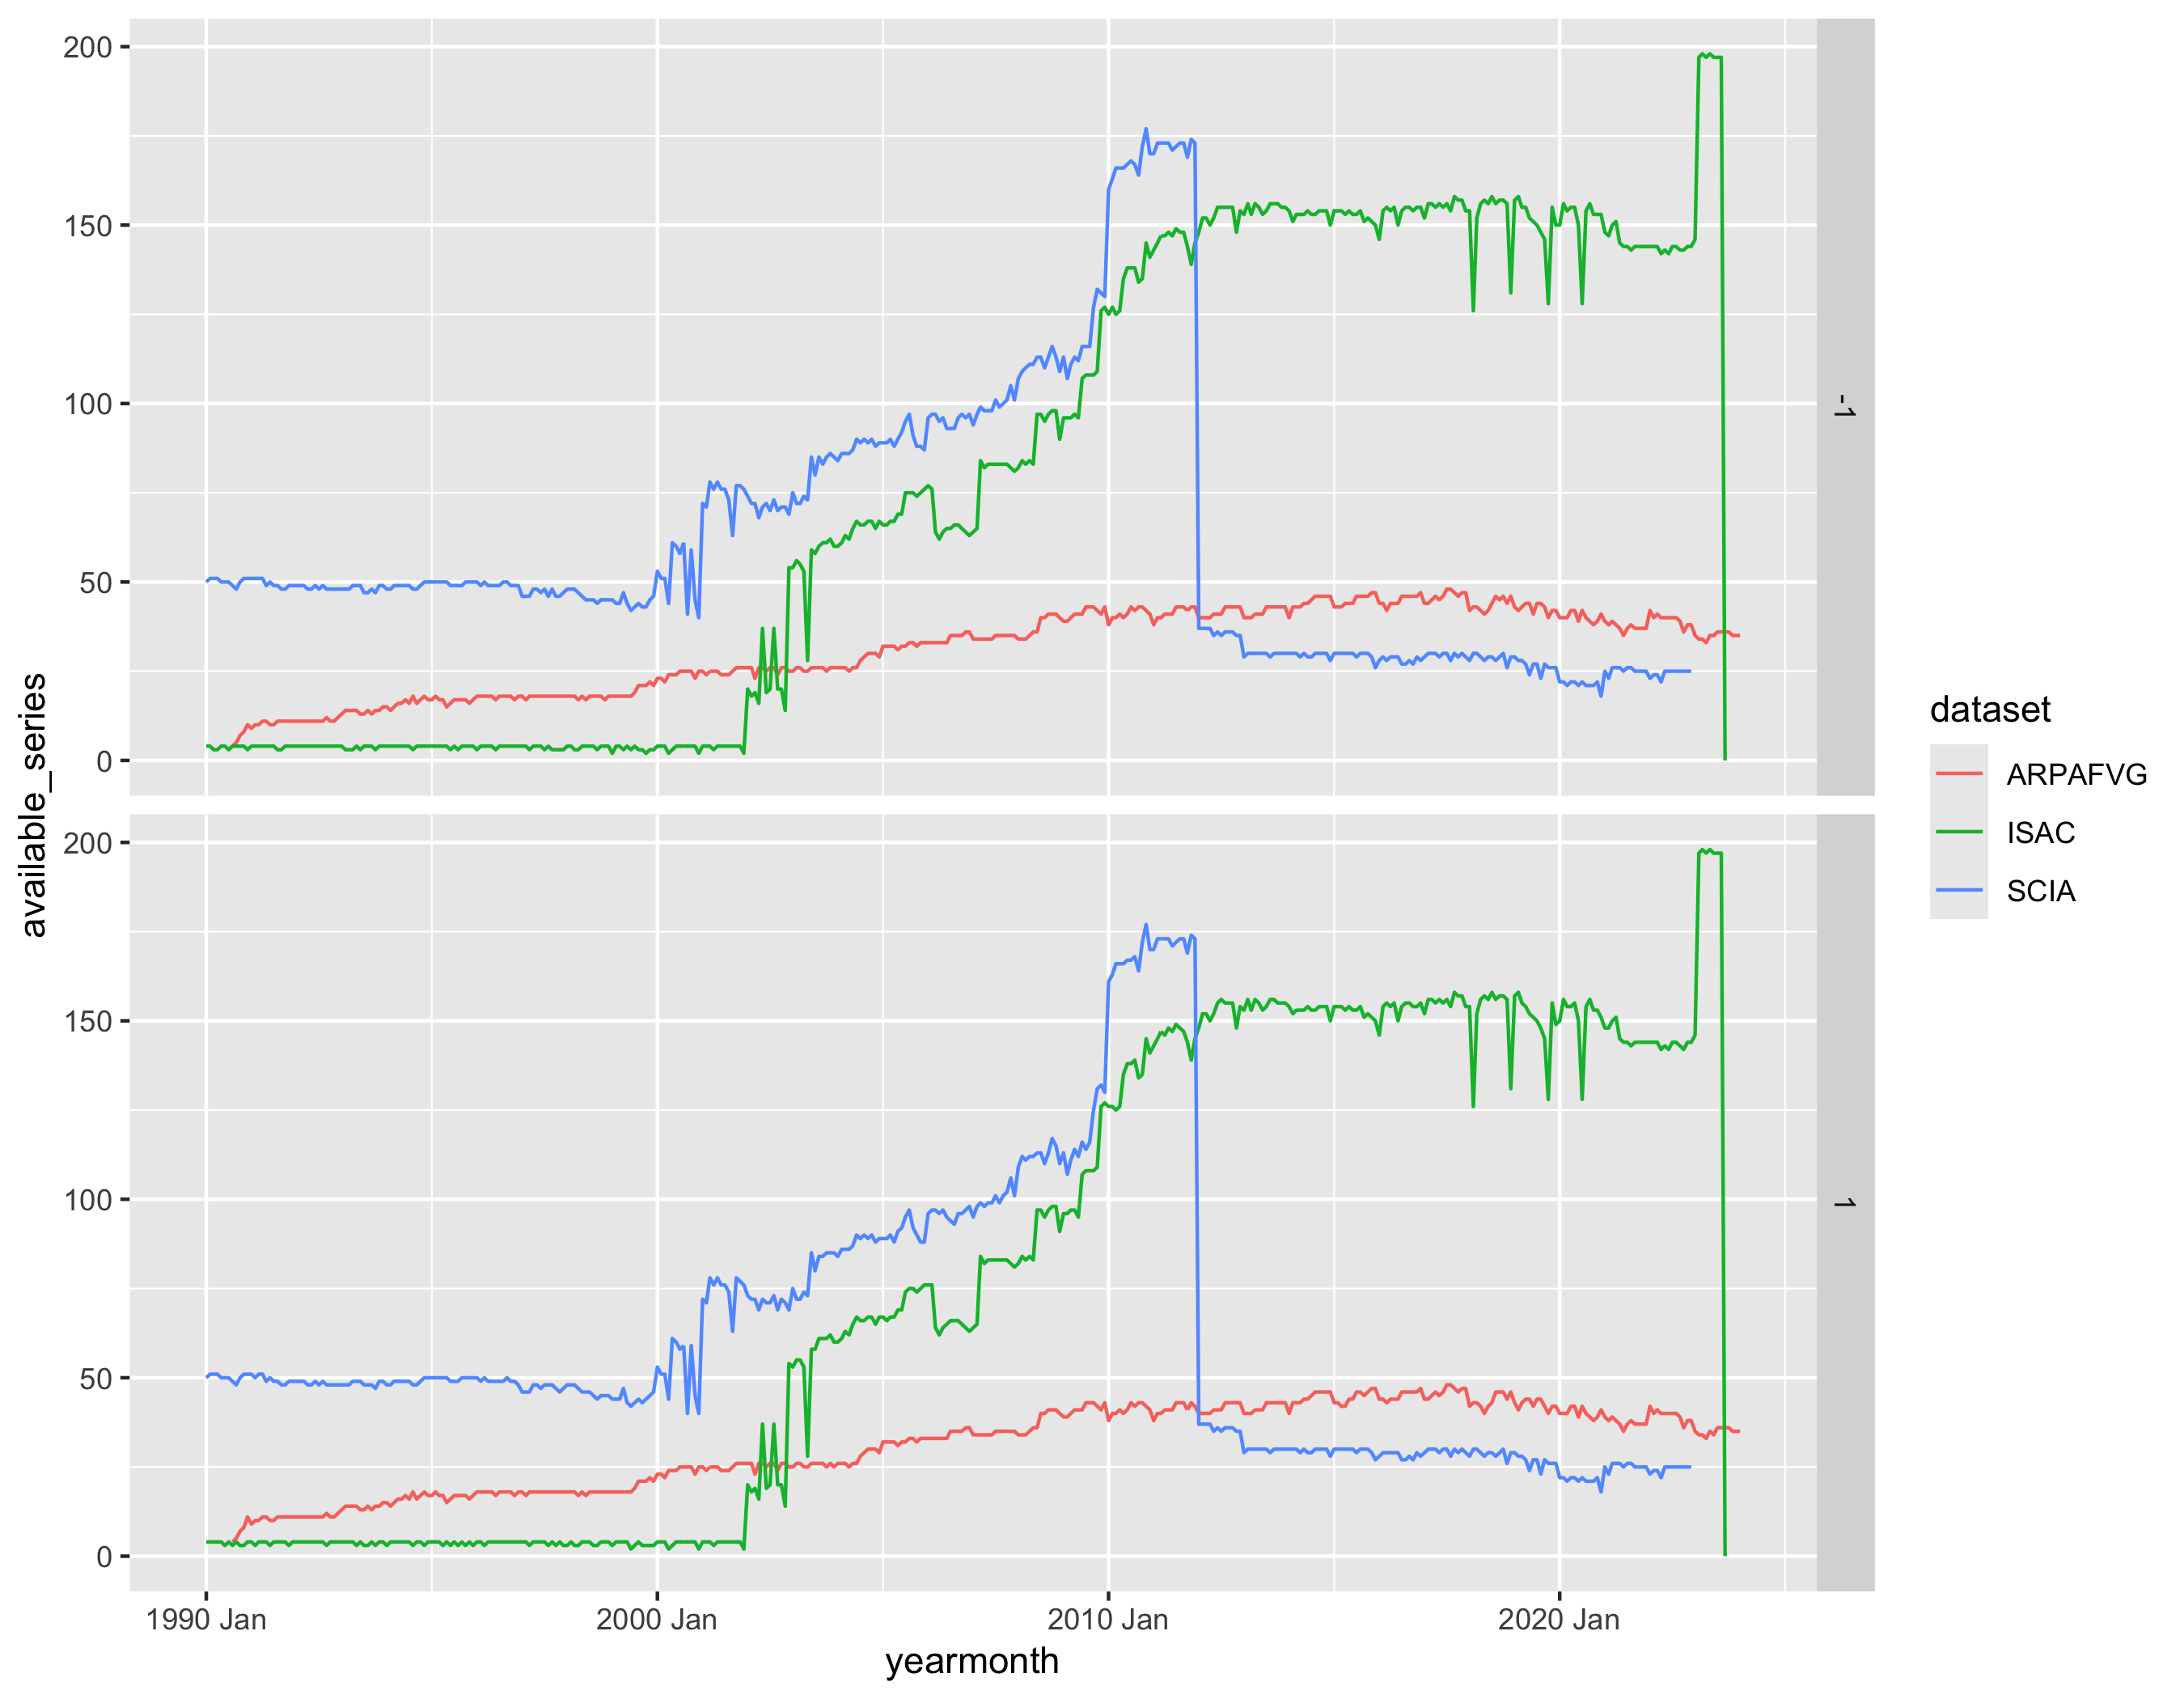

In [5]:
conn <- conns$data
stations <- query_checkpoint_meta(c(dataset, "SCIA", "ISAC"), "qc1", conn) |> filter(state == "Friuli-Venezia Giulia")
state_data <- query_checkpoint_data(c(dataset, "SCIA", "ISAC"), "qc1", conn, hive_types = list("valid" = "BOOLEAN", "variable" = "INT")) |>
    filter(date >= as.Date("1990-01-01"), valid) |>
    semi_join(stations, join_by(dataset, sensor_key))
pp <- ymonthly_availabilities(state_data)
pp$plot + facet_grid(variable ~ .)


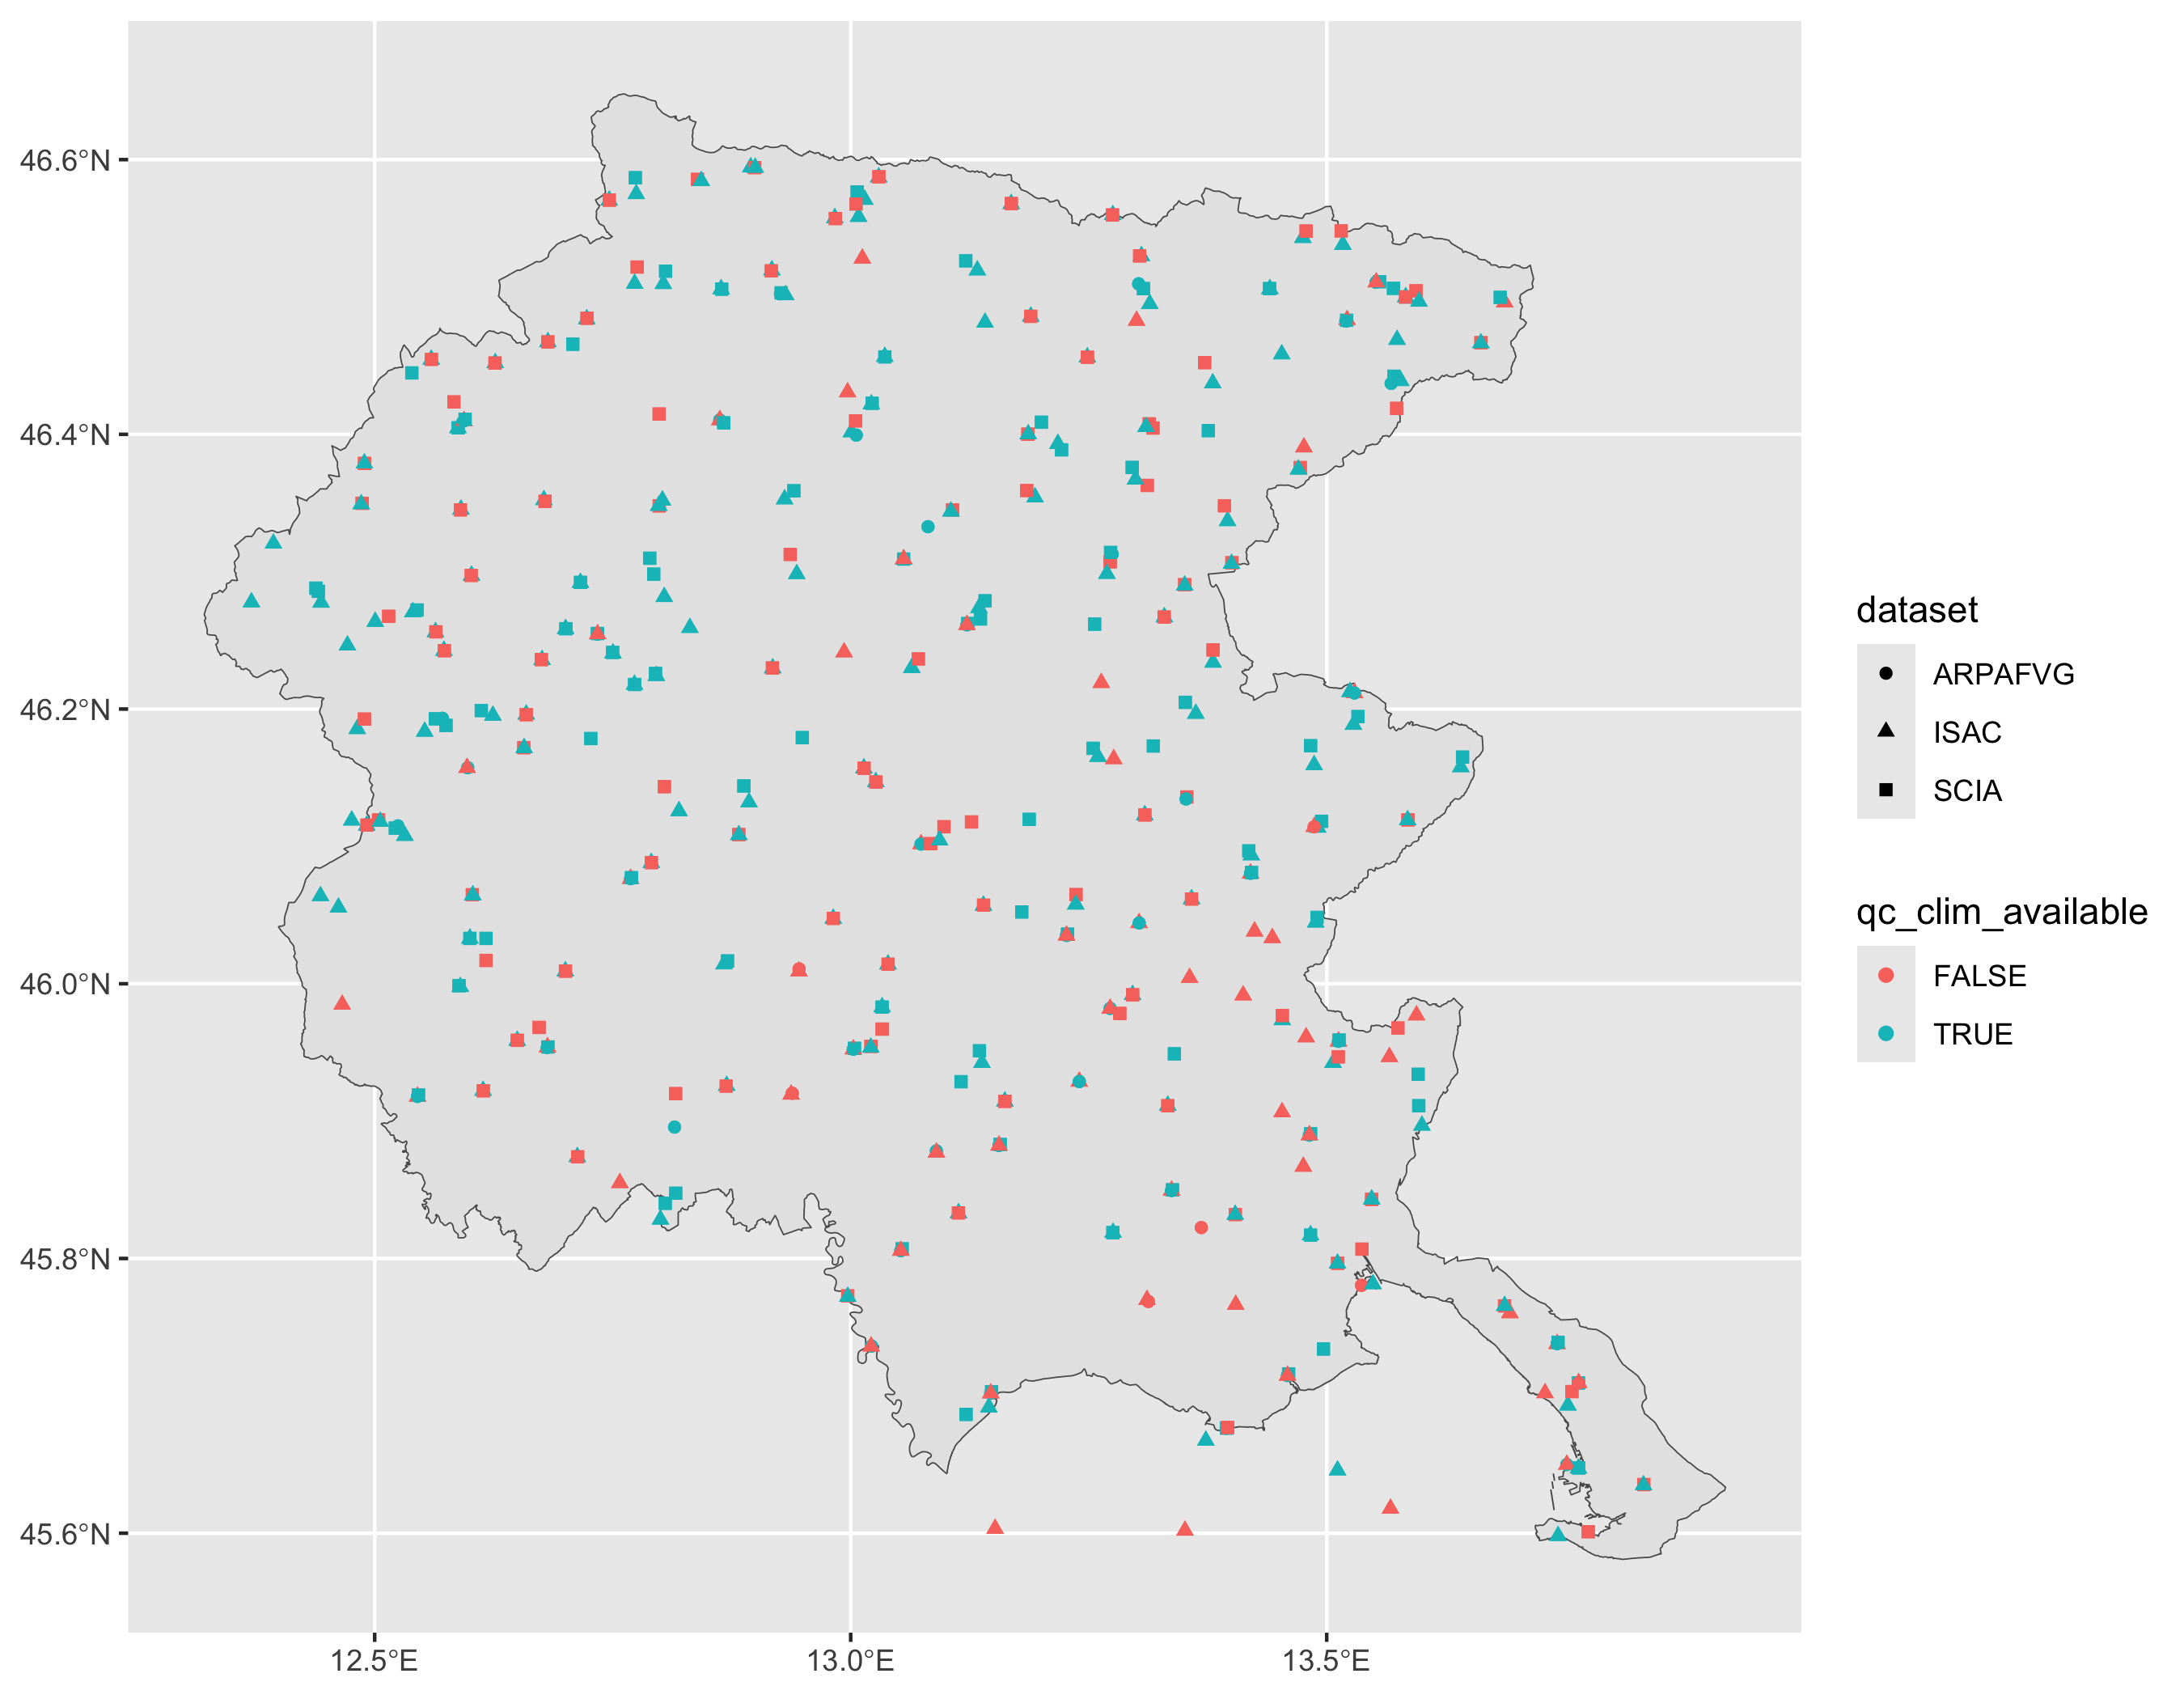

In [6]:
pp <- spatial_availabilities(pp$data, stations, state_boundaries)
pp$plot


In [8]:
pp$data |>
    group_by(dataset, qc_clim_available, variable) |>
    count()


dataset,qc_clim_available,variable,n
<chr>,<lgl>,<int>,<int>
ARPAFVG,FALSE,-1,8
ARPAFVG,FALSE,1,8
ARPAFVG,TRUE,-1,42
ARPAFVG,TRUE,1,42
ISAC,FALSE,-1,60
ISAC,FALSE,1,60
ISAC,TRUE,-1,151
ISAC,TRUE,1,151
SCIA,FALSE,-1,102
